In [52]:
import pandas as pd
import os
import numpy as np
import matplotlib.patches as mpatches
import matplotlib.pyplot  as plt
import datetime
import copy

from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.cluster import KMeans
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score, f1_score, auc, silhouette_score

from tslearn.metrics import dtw, soft_dtw
from tslearn.clustering import TimeSeriesKMeans
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, \
    TimeSeriesResampler
from tslearn.barycenters import \
    euclidean_barycenter, \
    dtw_barycenter_averaging, \
    dtw_barycenter_averaging_subgradient, \
    softdtw_barycenter

from minepy import MINE  
from math import exp, sqrt, floor

import tensorflow as tf
import tqdm.notebook as tq
from tqdm.notebook import tqdm
import gc
import psutil
import logging
import seaborn as sns; sns.set()  # for plot styling


tf.get_logger().setLevel(logging.ERROR)

psutil.virtual_memory()
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# data acquisition and pre-processing

## data acquisition

In [8]:
def get_file_from_folder(path):
    data = {}
    data_path = path
    headers = ["MeterID", "Datetime", "Electricity"]

    for file_name in os.listdir(data_path):
        file_path = os.path.join(data_path, file_name)

        df = pd.read_csv(file_path, sep=" ", names=headers)
        data[file_name] = df

    return data

def transform_daycode_to_date(days_int):
    days = int(str(days_int)[:3])
    add_date = datetime.timedelta(days=days)
    current_date = START_DATE + add_date
    return str(current_date)

def transform_dataframe(df):
    df = df.sort_values(by = ['MeterID', 'Datetime'])

    df["Day"] = df["Datetime"].map(lambda x: transform_daycode_to_date(x))
    df["Time"] = df["Datetime"].map(lambda x: str(x)[3:])
    df["Time"] = pd.to_numeric(df["Time"], downcast='integer')

    df = df[['MeterID','Day', 'Time', 'Electricity', 'Datetime']]
    return df

def print_df_summary(df, all=False):
    print(f"MeterID count : {df.value_counts('MeterID').unique()}")
    print(f"Datetime count : {df.value_counts('Datetime').unique()}")
    if all == True:
        print(f"Day count : {df.value_counts('Day').unique()}")
        print(f"Time count : {df.value_counts('Time').unique()}")
        print(f"Electricity count : {df.value_counts('Electricity').unique()}")

In [9]:
# data preprocessing CONST
DATA_FOLDER_PATH = "Data"
IMAGES_PATH = "Image"
ALLOCATION_PATH = "SME and Residential allocations.xlsx"
START_DATE = datetime.date(2009, 1, 1)
MAX_NUMBER_OF_HOURS = 530 * 24 * 2
HOURS_LIST = np.arange(MAX_NUMBER_OF_HOURS)

In [10]:
# read data from folder
data = get_file_from_folder(DATA_FOLDER_PATH)

In [17]:
# get residential list
res_list = []
df_sme = pd.read_excel(ALLOCATION_PATH, usecols="A:B")
df_sme = df_sme.loc[df_sme['Code'] == 1]
res_list = df_sme['ID'].tolist()

In [18]:
# filter res data and specific date
res_data_list = []
for index, name in enumerate(data):
    d = data[name]['MeterID'].isin(res_list)
    d_is_res = data[name].loc[d]
    
    d_is_res_and_date = transform_dataframe(d_is_res)
    
    res_data_list.append(d_is_res_and_date)

In [19]:
load_data = pd.concat(res_data_list, copy=False)
load_data.head(10)

,MeterID,Day,Time,Electricity,Datetime
94856,4001,2009-07-15,1,0.281,19501
94857,4001,2009-07-15,2,0.255,19502
94858,4001,2009-07-15,3,0.186,19503
94859,4001,2009-07-15,4,0.214,19504
94860,4001,2009-07-15,5,0.276,19505
94861,4001,2009-07-15,6,0.192,19506
94862,4001,2009-07-15,7,0.236,19507
94863,4001,2009-07-15,8,0.185,19508
94864,4001,2009-07-15,9,0.196,19509
94865,4001,2009-07-15,10,0.249,19510


In [20]:
load_data.shape

(108678770, 5)

## Data cleaning

In [21]:
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300, image_path = IMAGES_PATH):
    path = os.path.join(image_path, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [22]:
def plot_day_data(data, x="Day", rotation=45, y="Data quantity", title="data quantity for each day in residential meter",save=False):
    plt.figure(dpi=150, figsize=(10,4))
    plt.plot(data)

    # naming the x axis 
    plt.xlabel(x) 
    plt.xticks(np.arange(0, len(data), 20), rotation=45)
    # naming the y axis 
    plt.ylabel(y) 

    # giving a title to my graph 
    plt.title(title)
    if save == True:
        save_fig(title)

In [23]:
# data cleaning functions
# drop data has eletricity comsuption with 0
def data_cleaning_drop_zero(pretty_data):
    print(f'before drop zero: {pretty_data.shape}')
    pretty_data = pretty_data.groupby("MeterID")
    pretty_data = pretty_data.filter(lambda x: ( round(x['Electricity'].eq(0).sum() / x['Electricity'].count(), 2) < 0.01) )
    print(f'after drop zero:  {pretty_data.shape}')
    return pretty_data

# drop data has more than T hours
def data_cleaning_drop_48(pretty_data, time=48):
    print(f'before drop Time: {pretty_data.shape}')
    pretty_data = pretty_data[ pd.to_numeric(pretty_data["Time"], downcast='integer') <= time ]
    print(f'after drop Time:  {pretty_data.shape}')
    return pretty_data

# select data between min and max Datetime 
def data_cleaning_select_time(pretty_data, min_date, max_date):
    print(f'before drop Datetime between {min_date} and {max_date}:  {pretty_data.shape}')
    pretty_data = pretty_data[ ((pretty_data['Datetime'] >= min_date) & (pretty_data['Datetime'] <= max_date)) ]
    print(f'after drop Datetime between {min_date} and {max_date}:  {pretty_data.shape}')
    return pretty_data

# drop data from specific column and specific value
def drop_meter_from_df(pretty_data, column, value):
    return pretty_data[~pretty_data[column].isin(value)]

def plot_df_valuecounts_with_groupby(pretty_data, byColumn, column=False):
    print(pretty_data.groupby(byColumn).count()["Time"].value_counts())
    if column:
        pretty_data.groupby(byColumn).count()[column].value_counts().plot.bar()
    else:
        pretty_data.groupby(byColumn).count().value_counts().plot.bar()
        
def replace_missing_value(df, meter_id, meter_day, replace_day, day_interval=1): 
    #day_interval is used to change the datetime
    #meter_day is the day with data
    #replace_day is the missing day
    display(df[ (df["MeterID"]==meter_id) & (df["Day"]==replace_day)].head(2))
    df_temp = df[ (df["MeterID"]==meter_id) & (df["Day"]==meter_day)]
    df_temp = df_temp.replace(to_replace=r""+meter_day, value=replace_day)
    df_temp["Datetime"] = df_temp["Datetime"].add(day_interval*100)
    df = df.append(df_temp)
    display(df[ (df["MeterID"]==meter_id) & (df["Day"]==replace_day)].head(2))
    return df

Saving figure data quantity for each day in residential meter


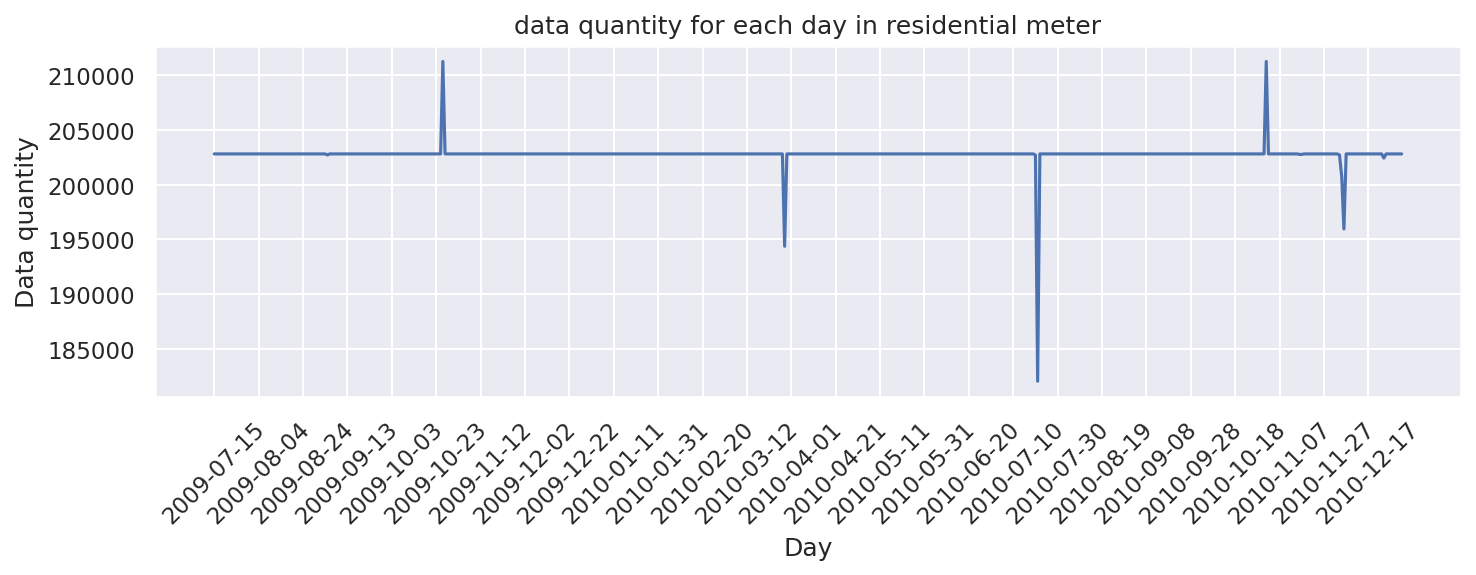

In [26]:
plot_day_data(load_data["Day"].value_counts().sort_index(), title="data quantity for each day in residential meter", save=True)

### select time interval

before drop Datetime between 19501 and 72948:  (108678770, 5)
after drop Datetime between 19501 and 72948:  (108475970, 5)
Saving figure data quantity in select time 2009.7.15-2010.12.31
(108475970, 5)
before drop Datetime between 73001 and 73048:  (108475970, 5)
after drop Datetime between 73001 and 73048:  (0, 5)


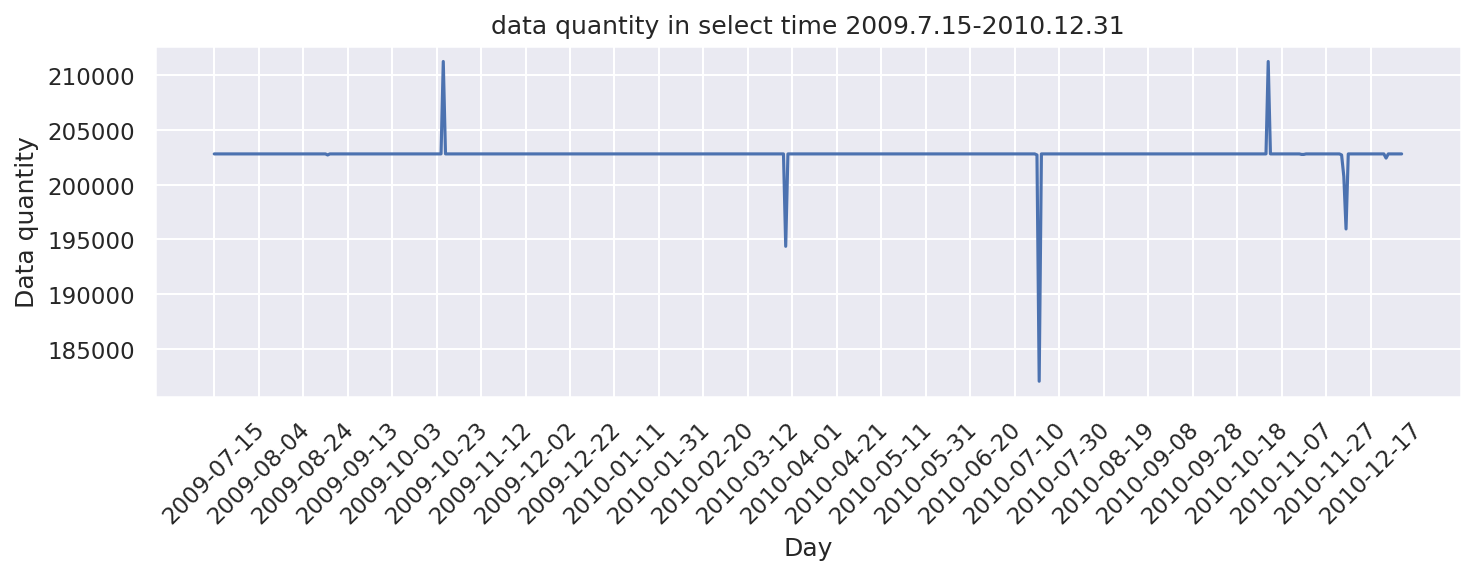

In [27]:
load_data = data_cleaning_select_time(load_data,19501,72948)
plot_day_data(load_data["Day"].value_counts().sort_index(), title="data quantity in select time 2009.7.15-2010.12.31", save=True)
print(load_data.shape)
data_20110101 = data_cleaning_select_time(load_data,73001,73048)

### drop more than 48 hours

before drop Time: (108475970, 5)
after drop Time:  (108459070, 5)
Saving figure drop data more than 48 hours a day
(108459070, 5)


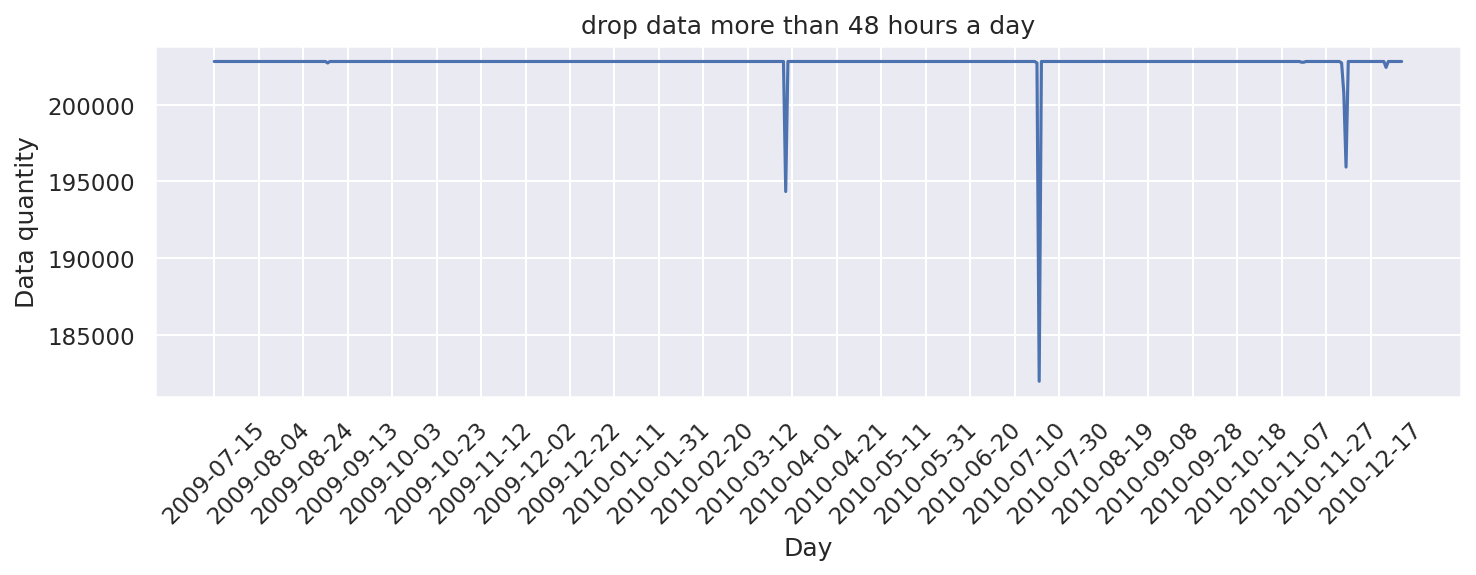

In [28]:
load_data = data_cleaning_drop_48(load_data)
plot_day_data(load_data["Day"].value_counts().sort_index(), title="drop data more than 48 hours a day", save=True)
print(load_data.shape)

### drop missing value

 2010-12-24    202416
 2010-12-05    200736
 2010-12-06    195936
 2010-03-29    194350
 2010-07-21    182016

Saving figure drop data with day missing
(107483616, 5)


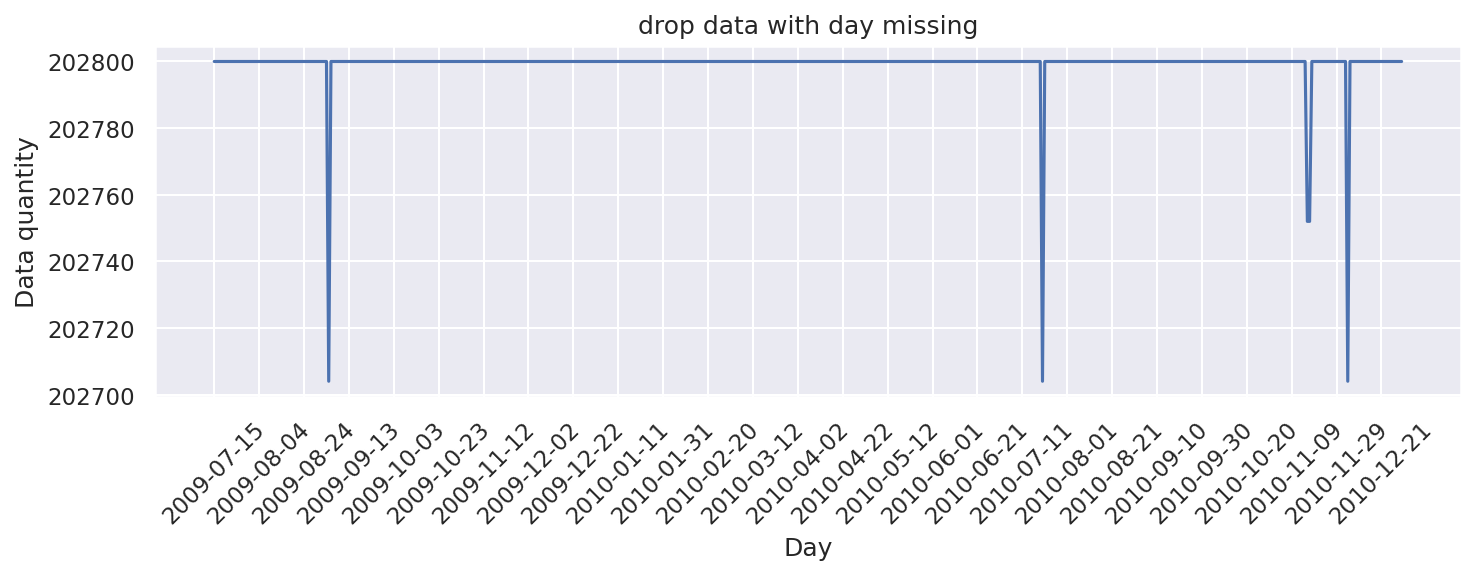

In [29]:
# drop data with day missing
drop_Day_missing = ["2010-03-29", "2010-12-24", "2010-12-05", "2010-12-06", "2010-07-21"]
load_data = drop_meter_from_df(load_data, "Day", drop_Day_missing)
plot_day_data(load_data["Day"].value_counts().sort_index(), title="drop data with day missing", save=True)
print(load_data.shape)

### replace missing value

 2010-11-17    202752
 2010-11-16    202752
 2009-09-04    202704
 2010-07-20    202704
 2010-12-04    202704

In [30]:
print(set(load_data["MeterID"].unique()) - set(load_data[ load_data["Day"]=="2010-11-16"]["MeterID"].unique()))
print(set(load_data["MeterID"].unique()) - set(load_data[ load_data["Day"]=="2010-11-17"]["MeterID"].unique()))
print(set(load_data["MeterID"].unique()) - set(load_data[ load_data["Day"]=="2009-09-04"]["MeterID"].unique()))
print(set(load_data["MeterID"].unique()) - set(load_data[ load_data["Day"]=="2010-07-20"]["MeterID"].unique()))
print(set(load_data["MeterID"].unique()) - set(load_data[ load_data["Day"]=="2010-12-04"]["MeterID"].unique()))

{4463}
{4463}
{5313, 2715}
{3433, 5181}
{2728, 1505}


In [31]:
load_data = replace_missing_value(load_data, 4463, "2010-11-15", "2010-11-16", 1)
load_data = replace_missing_value(load_data, 4463, "2010-11-14", "2010-11-17", 1)
load_data = replace_missing_value(load_data, 2715, "2009-09-03", "2009-09-04", 1)
load_data = replace_missing_value(load_data, 5313, "2009-09-03", "2009-09-04", 1)
load_data = replace_missing_value(load_data, 3433, "2010-07-19", "2010-07-20", 1)
load_data = replace_missing_value(load_data, 5181, "2010-07-19", "2010-07-20", 1)
load_data = replace_missing_value(load_data, 1505, "2010-12-03", "2010-12-04", 1)
load_data = replace_missing_value(load_data, 2728, "2010-12-03", "2010-12-04", 1)

,MeterID,Day,Time,Electricity,Datetime


,MeterID,Day,Time,Electricity,Datetime
22608208,4463,2010-11-16,1,0.479,68401
22608209,4463,2010-11-16,2,0.409,68402


,MeterID,Day,Time,Electricity,Datetime


,MeterID,Day,Time,Electricity,Datetime
22608160,4463,2010-11-17,1,0.441,68301
22608161,4463,2010-11-17,2,0.405,68302


,MeterID,Day,Time,Electricity,Datetime


,MeterID,Day,Time,Electricity,Datetime
2371104,2715,2009-09-04,1,0.089,24601
2371105,2715,2009-09-04,2,0.048,24602


,MeterID,Day,Time,Electricity,Datetime


,MeterID,Day,Time,Electricity,Datetime
2379264,5313,2009-09-04,1,0.154,24601
2379265,5313,2009-09-04,2,0.179,24602


,MeterID,Day,Time,Electricity,Datetime


,MeterID,Day,Time,Electricity,Datetime
17088619,3433,2010-07-20,1,0.611,56501
17088620,3433,2010-07-20,2,0.253,56502


,MeterID,Day,Time,Electricity,Datetime


,MeterID,Day,Time,Electricity,Datetime
17107983,5181,2010-07-20,1,0.558,56501
17107988,5181,2010-07-20,2,0.548,56502


,MeterID,Day,Time,Electricity,Datetime


,MeterID,Day,Time,Electricity,Datetime
23198590,1505,2010-12-04,1,0.0,70201
23198591,1505,2010-12-04,2,0.0,70202


,MeterID,Day,Time,Electricity,Datetime


,MeterID,Day,Time,Electricity,Datetime
23201700,2728,2010-12-04,1,0.923,70201
23201701,2728,2010-12-04,2,0.253,70202


Saving figure fill data with day missing
(107484000, 5)


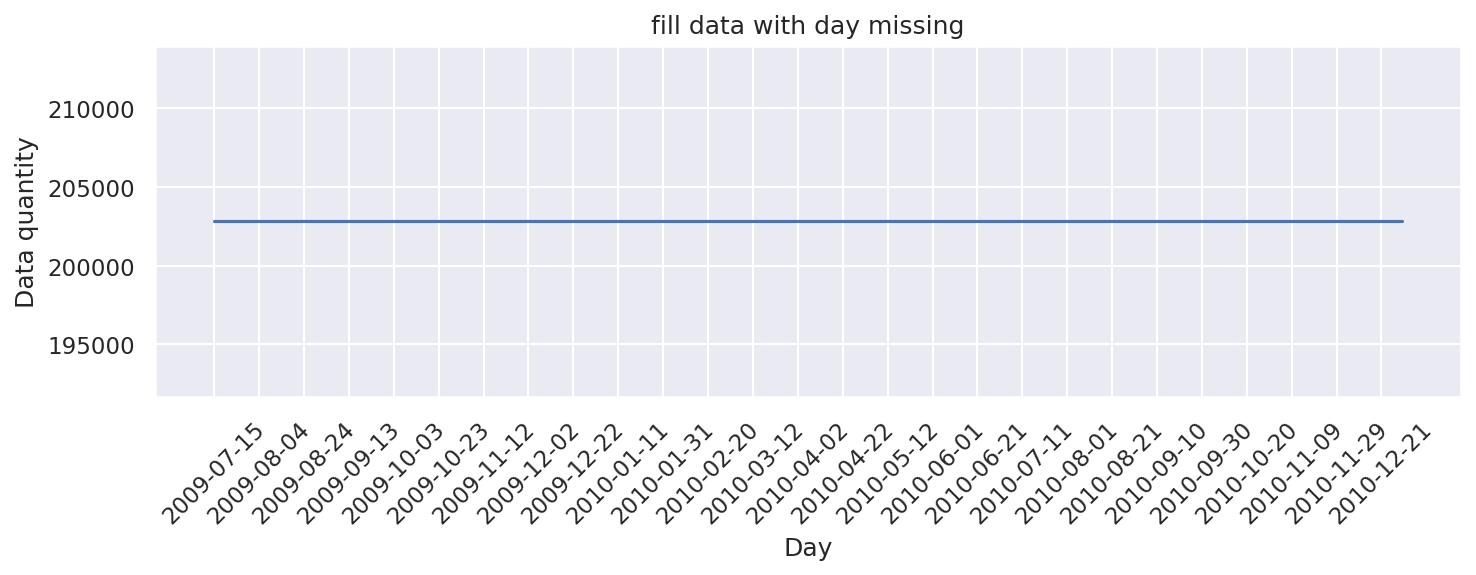

In [32]:
plot_day_data(load_data["Day"].value_counts().sort_index(), title="fill data with day missing", save=True)
print(load_data.shape)

In [33]:
del data
del d
del df_sme
del d_is_res
del res_list
del d_is_res_and_date
del res_data_list
gc.collect()

19109

## Meter grouping

In [34]:
pretty_data = load_data.sort_values(by=['MeterID', 'Day'])

In [35]:
# FDI CONST
NUMBER_OF_DAYS = len(pretty_data["Day"].unique())
NUMBER_OF_HALF_HOURS = NUMBER_OF_DAYS * 48
AREA_NUM = 10
TOTAL_METER = len(pretty_data.groupby("MeterID")["MeterID"].unique())
METER_IN_RANGE = round(len(pretty_data.groupby("MeterID")["MeterID"].unique()) / AREA_NUM)

In [36]:
NUMBER_OF_DAYS, NUMBER_OF_HALF_HOURS, TOTAL_METER, METER_IN_RANGE

(530, 25440, 4225, 422)

In [37]:
# split data into groups
def split_data_to_group(target_df, areas):
    data_group = {}
    for group in range(areas):
        if group == (AREA_NUM - 1):
            data_group[group] = target_df[METER_IN_RANGE*group*(NUMBER_OF_HALF_HOURS) : METER_IN_RANGE*(group+1)*(NUMBER_OF_HALF_HOURS)+NUMBER_OF_HALF_HOURS* (TOTAL_METER % areas)]
        else:
            data_group[group] = target_df[METER_IN_RANGE*group*(NUMBER_OF_HALF_HOURS) : METER_IN_RANGE*(group+1)*(NUMBER_OF_HALF_HOURS)]
    return data_group

In [38]:
# split data into 10 groups
data_group = split_data_to_group(pretty_data, AREA_NUM)

## FDI

In [39]:
class FdiGenerator:
    def __init__(self):
        self.alpha_max = 0.8
        self.alpha_min = 0.2
    
    # x is the origin value

    def fdi_1(self, x):
        fdi =  x * self.get_alpha()
        return fdi

    def fdi_2(self, x, df_max):
        alpha = self.get_alpha()
        gamma = alpha * df_max
        return gamma if (x > gamma) else x

    def fdi_3(self, x, df_max):
        gamma = np.random.uniform(0, 1) * df_max
        return max((x - gamma), 0)
    
    def fdi_4(self, x, index, total_index):
        t2 = np.random.randint(0, 20)
        t1 = np.random.randint(t2, 24)
        if index > t2 and index < t2:
            return 0
        return x
    
    def fdi_5(self, x, index):
        alpha = self.get_alpha()
        return x * alpha
    
    def fdi_6(self, avg_x):
        alpha = self.get_alpha()
        return avg_x * alpha
    
    def get_alpha(self):
        return np.random.uniform(self.alpha_min, self.alpha_max)
    
    def get_random_mode(self):
        # return an integer in range from 1 to 6
        fdi_method = np.random.randint(1, 7)
        return fdi_method
    
    def random_fdi(self, fdi_method, x, df, index):
        # return a fdi value with fdi_method provided
        if fdi_method == 1:
            return self.fdi_1(x)
        elif fdi_method == 2:
            return self.fdi_2(x, df.max())
        elif fdi_method == 3:
            return self.fdi_3(x, df.max())
        elif fdi_method == 4:
            return self.fdi_4(x, index, df.shape[0])
        elif fdi_method == 5:
            return self.fdi_5(x, index)
        else:
            return self.fdi_6(df.mean())

In [40]:
def split_group(group, total_meter, area_num, group_meter, total_day, ntl_meter_ratio, ntl_day_ratio):
    # ex: split_group(data_group, total_meter = 2044, group_meter = 204, total_day = 299, ntl_meter_ratio = 0.1, ntl_day_ratio = 0.5)

    ntl_num = round(group_meter * ntl_meter_ratio) # ntl_num = how many number of ntl meters
    ntl_day_num = round(total_day * ntl_day_ratio) # ntl_day_num = how many days are fdi for ntl meters
    
    np.random.seed(42)
    
    final_data_group = []
    origin_data_group = []
    data_group = copy.deepcopy(group) 
    
    # iterate through 10 area
    for group, data in data_group.items():
        
        final_data = {}
        origin_data = {}

        normal_data = []
        fdi_data = []
        origin_fdi_data = []

        if group == (area_num - 1): # the last group will have more data for the rest of the meters
            num = total_meter - group_meter * (area_num -1)
        else:
            num = group_meter

        #split total meter into normal meters and fdi meters
        rs = ShuffleSplit(n_splits=1, test_size=ntl_num)
        for normal_index, fdi_index in rs.split(range(num)):
            for index in normal_index:
                normal_data.append(data[index*(NUMBER_OF_HALF_HOURS):(index+1)*(NUMBER_OF_HALF_HOURS)])
            for index in fdi_index:
                fdi_data.append(data[index*(NUMBER_OF_HALF_HOURS):(index+1)*(NUMBER_OF_HALF_HOURS)])
                
        origin_fdi_data = copy.deepcopy(fdi_data)
            
        for index in tq.tqdm(range(len(fdi_data))):

            dataframe = fdi_data[index]
            fdi_dataframe = np.zeros((NUMBER_OF_HALF_HOURS))
            
            # split total day into normal and fdi day with the ntl_day_num
            rs = ShuffleSplit(n_splits=1, test_size=ntl_day_num, random_state=42)
            for normal_day, fdi_day in rs.split(range(total_day)):
                normal_day = normal_day
                fdi_day = fdi_day
            
            # set normal data in normal days
            for day in range(len(normal_day)):
                for i in range(normal_day[day]*48, (normal_day[day]+1)*48):
                    fdi_dataframe[i] = dataframe["Electricity"].iloc[[i]]
            
            # process FDI in fdi days
            for day in range(len(fdi_day)):
                  for i in range(fdi_day[day]*48, (fdi_day[day]+1)*48):
                        
                        # one day has 48 data, so every 48 will change a fdi mode
                        if i%48 == 0:
                            fdi_method = FDI.get_random_mode()
                        
                        origin_value = dataframe["Electricity"].iloc[i]
                        fdi_dataframe[i] = FDI.random_fdi(fdi_method, origin_value, dataframe["Electricity"], i)

            fdi_data[index]["Electricity"] = fdi_dataframe

        final_data["normal"] = normal_data
        final_data["fdi"] = fdi_data
        final_data_group.append(final_data) 

        origin_data["normal"] = normal_data
        origin_data["fdi"] = origin_fdi_data
        origin_data_group.append(origin_data)

    return final_data_group, origin_data_group

In [41]:
FDI = FdiGenerator()
final_data_group, origin_data_group = split_group(data_group, total_meter=TOTAL_METER, area_num=AREA_NUM, total_day=NUMBER_OF_DAYS, group_meter=METER_IN_RANGE, ntl_meter_ratio=0.1, ntl_day_ratio=0.5)

  0%|          | 0/42 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

In [42]:
def plot_data(normal_data, fdi_data, title, label1, label2, plot_house=5, plot_hour=120, save=False):
    #plotting the points  
    plt.figure(dpi=150, figsize=(15,4))
    if normal_data is not None:
        count = 0
    for i in range(len(normal_data)):
        data = normal_data[i]["Electricity"]
        count += 1
        if count>plot_house:
            break
        plt.plot(HOURS_LIST[:plot_hour], data[:plot_hour], color='blue') 

    if fdi_data is not None:
        count = 0
    for i in range(len(fdi_data)):
        data = fdi_data[i]["Electricity"]
        count += 1
        if count>plot_house:
            break
        plt.plot(HOURS_LIST[:plot_hour], data[:plot_hour], color='red')
    
    
    blue_patch = mpatches.Patch(color='blue', label=label1)
    red_patch = mpatches.Patch(color='red', label=label2)
    plt.legend(handles=[blue_patch, red_patch])       
        
    # naming the x axis 
    plt.xlabel('Half Hours') 
    # naming the y axis 
    plt.ylabel('Electricity Consumption(W)') 

    # giving a title to my graph 
    plt.title(title) 

    # function to save the plot
    if save == True:
        save_fig(title)

    # function to show the plot 
    plt.show()

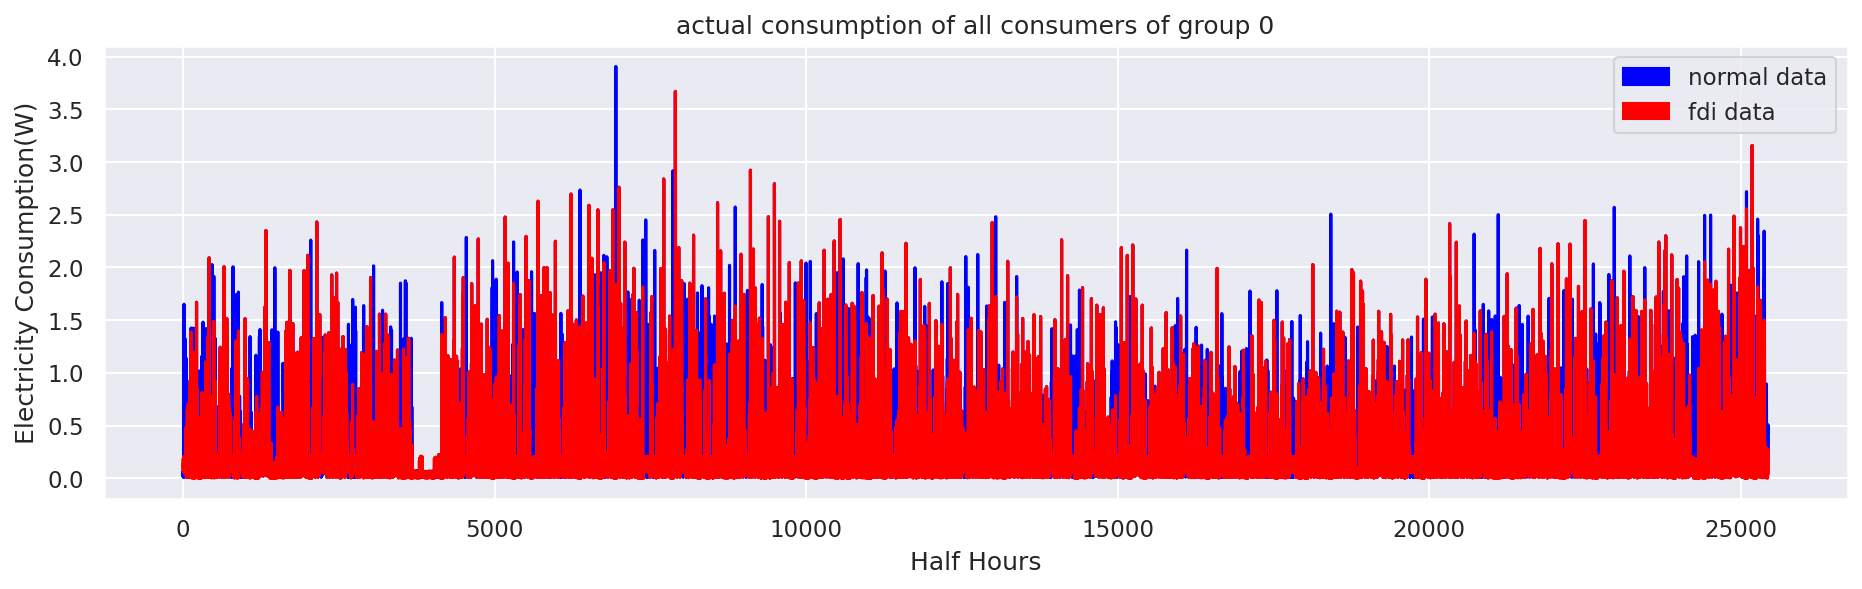

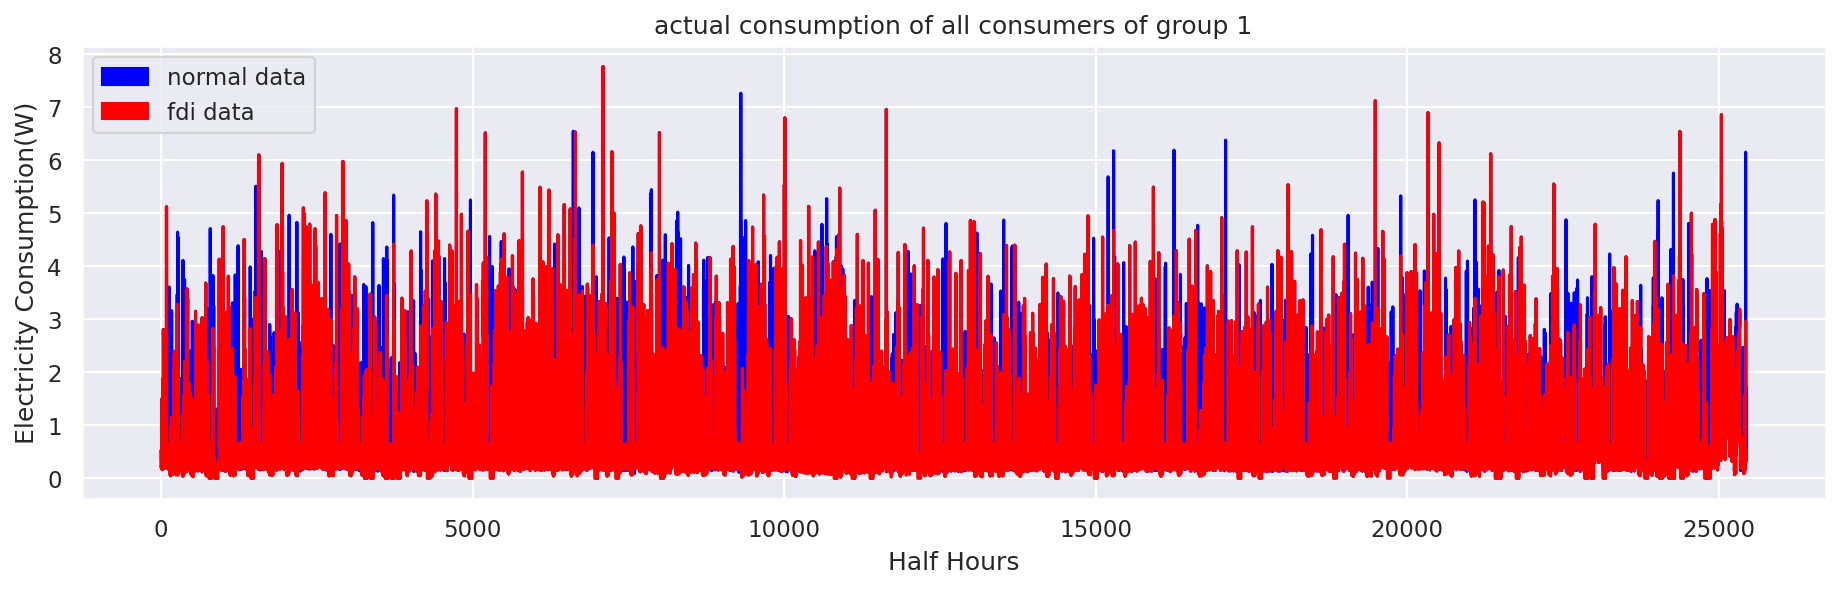

In [43]:
for i in range(len(final_data_group)):
    if i == 2: break
    plot_data(origin_data_group[i]["fdi"], final_data_group[i]["fdi"], "actual consumption of all consumers of group " + str(i), "normal data", "fdi data", plot_house=1, plot_hour=NUMBER_OF_HALF_HOURS, save=False)

In [45]:
e = pretty_data.to_csv(index=False)
f = open('pretty_data.csv','w')
f.write(e) #Give your csv text here.
## Python will convert \n to os.linesep
f.close()

## check NTL

In [44]:
# observe_meter_data_group = copy.deepcopy(origin_data_group) ## data without fdi
# smart_meter_data_group = copy.deepcopy(final_data_group) ## data with fdi
observe_meter_data_group = origin_data_group ## data without fdi
smart_meter_data_group = final_data_group ## data with fdi

In [177]:
# smart_meter_list = []
# smart_meter_df = pd.DataFrame(columns=['MeterID', 'Day', 'FDI','Electricity'])
# pbar = tqdm(smart_meter_data_group) 
# for area in pbar: # iterate 10 data groups
#     for meter in area['fdi']: # iterate every fdi meter in area 
#         meter['FDI']='True'
#         smart_meter_list.append(meter.to_numpy())
#     for meter in area['normal']:
#         meter['FDI']='False'
#         smart_meter_list.append(meter.to_numpy())
# #             se = {'MeterID': meter_id, 'Day': meter_day,'FDI':True }
# #             v_value_list.append(se)

# df = pd.DataFrame(np.array(smart_meter_list).reshape(-1, 6), columns=["MeterID","Day","Time","Electricity","Datetime", "FDI"])
# df.head()
# df = df[["MeterID","Day","Time","Electricity","FDI"]]
# e = df.to_csv(index=False)
# f = open('smart_meter.csv','w')
# f.write(e) #Give your csv text here.
# f.close()

  0%|          | 0/10 [00:00<?, ?it/s]

In [31]:
# calculate NTL loss vector for every day
ntl_loss_data_group = []
for observe_area, smart_area in zip(observe_meter_data_group, smart_meter_data_group): # iterate 10 area
    ntl_loss_data = []
    for observe_meter, smart_meter in zip(observe_area['fdi'], smart_area['fdi']): #iterate fdi meter in each area
        
        sub = observe_meter[["Electricity"]] - smart_meter[["Electricity"]]

        ntl_loss_data = sub.to_numpy().reshape(NUMBER_OF_DAYS, 48) 

    ntl_loss_data_group.append(ntl_loss_data)
ntl_loss_data_group = np.asarray(ntl_loss_data_group)
ntl_loss_data_group.shape

(10, 530, 48)

 0.000000    16306
 0.012000      214
 0.013000      113
 0.066000       53
 0.011000       43
             ...  
 0.007365        1
-0.168375        1
 0.169100        1
-0.060166        1
 0.797000        1
Name: Electricity, Length: 7300, dtype: int64


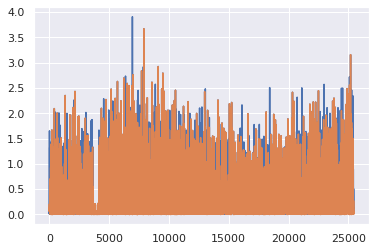

In [32]:
# make sure there is difference between the observe_meter_data_group and smart_meter_data_group
plt.plot(observe_meter_data_group[0]["fdi"][0]["Electricity"].tolist())
plt.plot(smart_meter_data_group[0]["fdi"][0]["Electricity"].tolist()) 
for j in range(1):
    t = observe_meter_data_group[0]["fdi"][j]["Electricity"] - smart_meter_data_group[0]["fdi"][j]["Electricity"]
    print(t.value_counts())

# k-mean index

In [52]:
X = []
X_meter = []
Y = []
for i in range(10):
    data = final_data_group[i]
    for normal in data["normal"]:
        X.append(normal["Electricity"].to_numpy())
        X_meter.append(normal["MeterID"].iloc[0])
        Y.append([0])
    for fdi in data["fdi"]:
        X.append(fdi["Electricity"].to_numpy())
        X_meter.append(normal["MeterID"].iloc[0])
        Y.append([1])
X = np.array(X)
X_meter = np.array(X_meter)
Y = np.array(Y).reshape(-1)
print(X.shape)

(4225, 25440)


In [1]:
print(Y.shape)

NameError: name 'Y' is not defined

### silhouette index

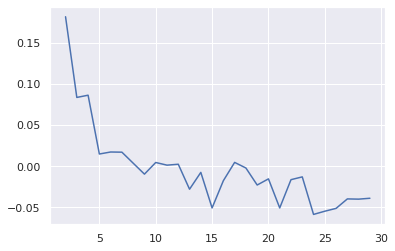

In [288]:
# silhouette index
silhouette_avg = []
for i in tq.tqdm(range(2,30)):
    kmeans_fit = KMeans(n_clusters = i).fit(X)
    silhouette_avg.append(silhouette_score(X, kmeans_fit.labels_))
plt.plot(range(2,30), silhouette_avg)

Saving figure Silhouette analysis in fdi data


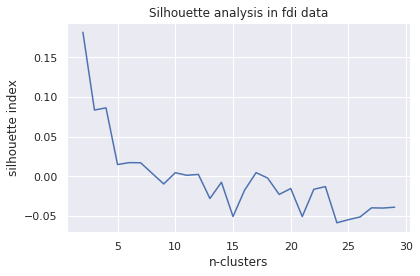

In [295]:
plt.title("Silhouette analysis in fdi data")
plt.xlabel('n-clusters') 
# naming the y axis 
plt.ylabel('silhouette index') 
plt.plot(range(2,30), silhouette_avg)
save_fig("Silhouette analysis in fdi data")

# feature extraction

## V-value

### normalization

In [54]:
# the value of x is divided by its
# maximum and scaled into a value between zero and one
# normalized smart_meter_data_group by divide the max eletricity of the meter
for area in smart_meter_data_group:
    for meter in area['fdi']:
        meter_numpy = meter['Electricity'].to_numpy()
        meter['Electricity'] = meter_numpy / meter_numpy.max()
    for meter in area['normal']:
        meter_numpy = meter['Electricity'].to_numpy()
        meter['Electricity'] = meter_numpy / meter_numpy.max()
smart_meter_data_group[0]['fdi'][0]['Electricity'].to_numpy()

array([0.03036384, 0.0293429 , 0.02573139, ..., 0.02866607, 0.02366506,
       0.04255409])

0.130453    174
0.127911    166
0.125370    161
0.123676    158
0.126217    155
           ... 
0.119941      1
0.572266      1
0.117637      1
0.350362      1
0.107493      1
Name: Electricity, Length: 8930, dtype: int64


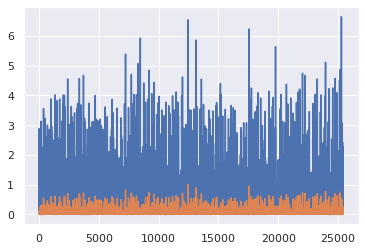

In [55]:
# make sure there is difference between the observe_meter_data_group and smart_meter_data_group
plt.plot(observe_meter_data_group[0]["fdi"][0]["Electricity"].tolist())
plt.plot(smart_meter_data_group[0]["fdi"][0]["Electricity"].tolist()) 
for j in range(1):
    t = observe_meter_data_group[0]["fdi"][j]["Electricity"] - smart_meter_data_group[0]["fdi"][j]["Electricity"]
    print(t.value_counts())

### calculate v-value

In [58]:
CONDITION_FILTER = 28
v_value_list = []
v_value_df = pd.DataFrame(columns=['MeterID', 'Day', 'FDI', 'Tmax1', 'Cmax1', 'Tmax2', 'Cmax2', 'Tmin1', 'Cmin1'])
pbar = tqdm(smart_meter_data_group) 
for area in pbar: # iterate 10 data groups
    for meter in area['fdi']: # iterate every fdi meter in area 
        day_list = meter['Day'].reset_index()
        for i in range(NUMBER_OF_DAYS): # iterate every day
            meter_id = meter['MeterID'].max()
            meter_day = day_list['Day'][i*48]
            meter_numpy = meter['Electricity'].to_numpy()[i*48:(i+1)*48]

            # 1. Cmax1 and T max1 are the maximum consumption before 2 p.m.
            Tmax1 = meter_numpy[:CONDITION_FILTER].argmax()
            
            # 2. Cmax2 and T max2 are the maximum consumption after 2 p.m.
            Tmax2 = meter_numpy[CONDITION_FILTER:].argmax() + CONDITION_FILTER
            
            # 3. Cmin1 and T min1 are the minimum consumption between T max1 and T max2 
            Tmin1 = meter_numpy[Tmax1: Tmax2].argmin() + Tmax1
            
            se = {'MeterID': meter_id, 'Day': meter_day,'FDI': True, 'Tmax1': Tmax1, 'Tmax2': Tmax2, 'Tmin1': Tmin1, 'Cmax1': meter_numpy[Tmax1], 'Cmax2': meter_numpy[Tmax2], 'Cmin1': meter_numpy[Tmin1]}
            v_value_list.append(se)
    print('finish fdi')
    for meter in area['normal']:
        day_list = meter['Day'].reset_index()
        for i in range(NUMBER_OF_DAYS): # iterate every day
            meter_id = meter['MeterID'].max()
            meter_day = day_list['Day'][i*48]
            meter_numpy = meter['Electricity'].to_numpy()[i*48:(i+1)*48]
#             print(meter_numpy)
            # 1. Cmax1 and T max1 are the maximum consumption before 2 p.m.
            Tmax1 = meter_numpy[:CONDITION_FILTER].argmax()
            
            # 2. Cmax2 and T max2 are the maximum consumption after 2 p.m.
            Tmax2 = meter_numpy[CONDITION_FILTER:].argmax() + CONDITION_FILTER
            
            # 3. Cmin1 and T min1 are the minimum consumption between T max1 and T max2 
            Tmin1 = meter_numpy[Tmax1: Tmax2].argmin() + Tmax1
            
            se = {'MeterID': meter_id, 'Day': meter_day,'FDI': False, 'Tmax1': Tmax1, 'Tmax2': Tmax2, 'Tmin1': Tmin1, 'Cmax1': meter_numpy[Tmax1], 'Cmax2': meter_numpy[Tmax2], 'Cmin1': meter_numpy[Tmin1]}
            v_value_list.append(se)
    print('finish normal')

  0%|          | 0/10 [00:00<?, ?it/s]

finish fdi
finish normal
finish fdi
finish normal
finish fdi
finish normal
finish fdi
finish normal
finish fdi
finish normal
finish fdi
finish normal
finish fdi
finish normal
finish fdi
finish normal
finish fdi
finish normal
finish fdi
finish normal


In [59]:
df = pd.DataFrame(v_value_list)
df.head()

,MeterID,Day,FDI,Tmax1,Tmax2,Tmin1,Cmax1,Cmax2,Cmin1
0,5212,2010-12-31,True,12,30,15,0.046464,0.047532,0.013561
1,5212,2010-12-31,True,27,38,36,0.217125,0.231040,0.021254
2,5212,2010-12-31,True,26,42,34,0.184098,0.277676,0.021560
3,5212,2010-12-31,True,0,28,0,0.000000,0.000000,0.000000
4,5212,2010-12-31,True,0,39,19,0.082569,0.313303,0.020948


In [63]:
e = df.to_csv(index=False)
f = open('v_value.csv','w')
f.write(e) #Give your csv text here.
## Python will convert \n to os.linesep
f.close()

In [ ]:
del meter_day
del meter_id
del meter_numpy
del e
del f
del df
gc.collect()

### calculate distance

In [193]:
def dV(i,j):
    return ( (i.Tmax1-j.Tmax1)**2 + (i.Cmax1-j.Cmax1)**2 )**0.5 + ( (i.Tmax2-j.Tmax2)**2 + (i.Cmax2-j.Cmax2)**2 )**0.5 + ( (i.Tmin1-j.Tmin1)**2 + (i.Cmin1-j.Cmin1)**2 )**0.5

In [ ]:
def calculate_distance(df):
    vvalue_distance_matrix = []
    for indexi, rowi in tq.tqdm(df.iterrows()):
        i_j_distance_arr = []
        for indexj, rowj in tq.tqdm(df.iterrows()):
            if indexi > indexj:
                i_j_distance_arr.append(vvalue_distance_matrix[indexj][indexi])
                continue
            i_j_distance_arr.append(dV(rowi, rowj))
        vvalue_distance_matrix.append(i_j_distance_arr)
    return vvalue_distance_matrix

## four time interval

1) Time Period 1: 10.30 P.M.–6.30 A.M.—overnight period (45:14) 17  
2) Time Period 2: 6.30–9.00 A.M.—breakfast period (14:18) 4  
3) Time Period 3: 9.00 A.M.–3.30 P.M.—daytime period (18:31)  14
4) Time Period 4: 3.30–10.30 P.M.—evening period.(31:45)  14

In [ ]:
df_list = []
fourtime_df = pd.DataFrame(columns=['MeterID', 'Day', 'FDI', 'overnight', 'breakfast', 'daytime', 'evening'])
pbar = tqdm(smart_meter_data_group) 
for area in pbar: # iterate 10 data groups
    for meter in area['fdi']: # iterate every fdi meter in area 
        day_list = meter['Day'].reset_index()
        for i in range(NUMBER_OF_DAYS): # iterate every day
            meter_id = meter['MeterID'].max()
            meter_day = day_list['Day'][i*48]
            
            if i == 0:
                meter_numpy = meter['Electricity'].to_numpy()[44:48]
                meter_numpy = np.append(meter_numpy, meter['Time'].to_numpy()[i*48:(i+1)*48-4])
            else:
                meter_numpy = meter['Electricity'].to_numpy()[i*48-4:(i+1)*48-4]
            
            overnight = np.average(meter_numpy[0:17])
            breakfast = np.average(meter_numpy[17:21])
            daytime = np.average(meter_numpy[21:35])
            evening = np.average(meter_numpy[35:48])

            se = {'MeterID': meter_id, 'Day': meter_day,'FDI': True, 'overnight': overnight, 'breakfast': breakfast, 'daytime': daytime, 'evening': evening}
            df_list.append(se)
            
    for meter in area['normal']: # iterate every fdi meter in area 
        for i in range(NUMBER_OF_DAYS): # iterate every day
            meter_id = meter['MeterID'].max()
            meter_day = day_list['Day'][i*48]
            
            if i == 0:
                meter_numpy = meter['Electricity'].to_numpy()[44:48]
                meter_numpy = np.append(meter_numpy, meter['Time'].to_numpy()[i*48:(i+1)*48-4])
            else:
                meter_numpy = meter['Electricity'].to_numpy()[i*48-4:(i+1)*48-4]
            
            overnight = np.average(meter_numpy[0:17])
            breakfast = np.average(meter_numpy[17:21])
            daytime = np.average(meter_numpy[21:35])
            evening = np.average(meter_numpy[35:48])

            se = {'MeterID': meter_id, 'Day': meter_day,'FDI': True, 'overnight': overnight, 'breakfast': breakfast, 'daytime': daytime, 'evening': evening}
            df_list.append(se)


In [75]:
df = pd.DataFrame(df_list)
df.head(), df.shape


(   MeterID         Day   FDI  overnight  breakfast    daytime    evening
 0     1236  2009-07-15  True   5.380015   15.50000  24.500000  38.000000
 1     1236  2009-07-16  True   0.084015    0.23875   0.201571   0.196692
 2     1236  2009-07-17  True   0.135647    0.17500   0.231000   0.408409
 3     1236  2009-07-18  True   0.083588    0.00000   0.000000   0.092168
 4     1236  2009-07-19  True   0.029882    0.24775   0.295500   0.250308,
 (2239250, 7))

In [67]:
e = df.to_csv(index=False)
f = open('four_time.csv','w')
f.write(e) #Give your csv text here.
f.close()

In [12]:
temp = pd.read_csv('four_time.csv')
temp.shape

(2239250, 7)

## TS barycenter

In [205]:
for i in data_group:
    print(data_group[i].shape[0]/(530*48))

422.0
422.0
422.0
422.0
422.0
422.0
422.0
422.0
422.0
427.0


In [62]:
def km_cluster(train_data, cluster_num, method="EU"):
    if method == "EU":
        eu_km = TimeSeriesKMeans(n_clusters=cluster_num, verbose=False, random_state=42)
        y_pred = eu_km.fit_predict(train_data)
        result = eu_km

    elif method == "DBA":
        dba_km = TimeSeriesKMeans(n_clusters=cluster_num,
                              n_init=2,
                              metric="dtw",
                              verbose=True,
                              max_iter_barycenter=10, n_jobs=-1,
                              random_state=42)

        y_pred = dba_km.fit_predict(train_data)
        result = dba_km

    
    elif method == "Soft-DTW":
        sdtw_km = TimeSeriesKMeans(n_clusters=cluster_num,
                           metric="softdtw",
                           metric_params={"gamma": .01},
                           verbose=True  ,
                           random_state=42, 
#                            n_jobs=-1 
                                  )
        y_pred = sdtw_km.fit_predict(train_data)
        result = sdtw_km
        
    plt.figure(dpi=100, figsize=(15,4))
    for yi in range(cluster_num):
        plt.subplot(2, 3, yi+1)
        for xx in train_data[y_pred == yi]:
            plt.plot(xx.ravel(), "k-", alpha=.2)
            if method == "EU":
                plt.plot(eu_km.cluster_centers_[yi].ravel(), "r-")
            elif method == "DBA":
                plt.plot(dba_km.cluster_centers_[yi].ravel(), "r-")
            elif method == "Soft-DTW":
                plt.plot(sdtw_km.cluster_centers_[yi].ravel(), "r-")
                
        plt.xlim(0, train_data.shape[0])
    #     plt.ylim(-4, 4)
        plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
                 transform=plt.gca().transAxes)
        if yi == 1:
            plt.title(method+"$k$-means")
    plt.show()
            
    return y_pred, result

### DBA one cluster, 24 hours

  0%|          | 0/10 [00:00<?, ?it/s]

(422, 12720)
(422, 530, 24)
Init 1


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.6s finished


28347.006 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.6s finished


4621.596 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.6s finished


4615.397 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.7s finished


4615.141 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.6s finished


4615.141 --> 
Init 2


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.6s finished


8878.683 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.6s finished


4645.456 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.6s finished


4644.687 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.7s finished


4644.687 --> 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.8s finished


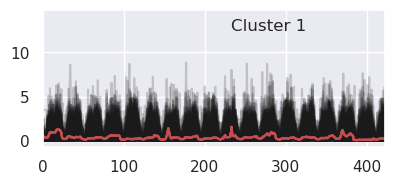

(422, 12720)
(422, 530, 24)
Init 1


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.7s finished


13324.232 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.6s finished


4144.097 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.8s finished


4140.409 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.6s finished


4140.273 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.6s finished


4140.273 --> 
Init 2


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.6s finished


7087.073 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.7s finished


4138.288 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.6s finished


4135.247 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.6s finished


4135.247 --> 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.6s finished


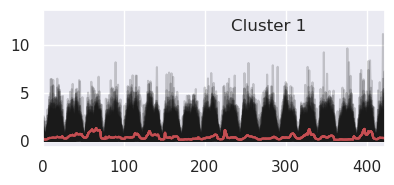

(422, 12720)
(422, 530, 24)
Init 1


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.6s finished


8044.920 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.6s finished


4388.607 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.6s finished


4386.613 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.6s finished


4386.613 --> 
Init 2


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.6s finished


8884.445 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.6s finished


4380.175 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.6s finished


4378.716 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.6s finished


4378.141 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.6s finished


4378.103 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.6s finished


4378.103 --> 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.6s finished


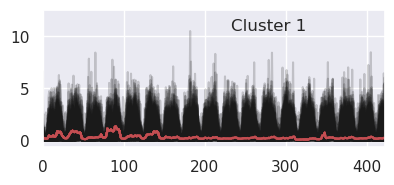

(422, 12720)
(422, 530, 24)
Init 1


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.6s finished


7175.066 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.6s finished


4213.277 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.6s finished


4208.406 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.6s finished


4208.368 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.7s finished


4208.368 --> 
Init 2


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.6s finished


6550.952 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.6s finished


4240.957 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.6s finished


4230.380 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.6s finished


4228.094 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.6s finished


4228.094 --> 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.6s finished


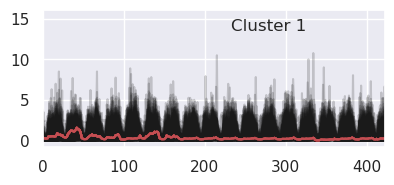

(422, 12720)
(422, 530, 24)
Init 1


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.6s finished


7678.539 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.6s finished


4230.188 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.6s finished


4227.383 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.7s finished


4226.905 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.6s finished


4226.905 --> 
Init 2


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.6s finished


7385.974 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.6s finished


4237.050 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.6s finished


4234.144 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.6s finished


4233.809 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.6s finished


4233.809 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.6s finished


4233.809 --> 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.6s finished


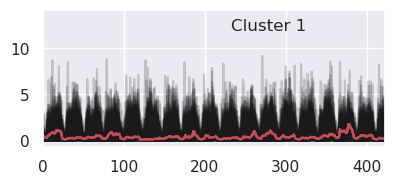

(422, 12720)
(422, 530, 24)
Init 1


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.6s finished


12600.882 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.6s finished


4177.116 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.6s finished


4174.205 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.6s finished


4172.780 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.6s finished


4172.217 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.6s finished


4172.217 --> 
Init 2


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.6s finished


6938.869 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.6s finished


4187.555 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.6s finished


4172.452 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.6s finished


4171.950 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.6s finished


4171.950 --> 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.6s finished


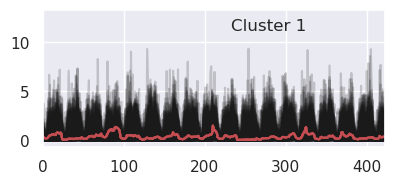

(422, 12720)
(422, 530, 24)
Init 1


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.6s finished


6843.651 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.6s finished


4435.394 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.6s finished


4410.493 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.6s finished


4405.808 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.6s finished


4405.730 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.6s finished


4405.730 --> 
Init 2


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.6s finished


9356.940 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.6s finished


4399.251 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.6s finished


4398.795 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.6s finished


4398.795 --> 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.6s finished


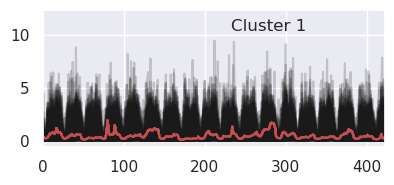

(422, 12720)
(422, 530, 24)
Init 1


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.6s finished


6474.921 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.6s finished


4176.702 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.6s finished


4159.493 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.6s finished


4159.376 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.6s finished


4159.376 --> 
Init 2


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.6s finished


10318.786 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.6s finished


4207.906 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.6s finished


4204.500 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.6s finished


4203.705 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.6s finished


4203.705 --> 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.6s finished


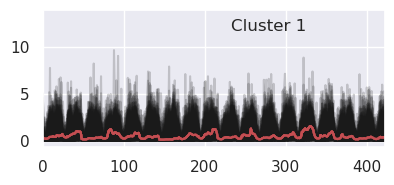

(422, 12720)
(422, 530, 24)
Init 1


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.6s finished


6482.377 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.6s finished


4042.554 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.6s finished


4040.145 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.6s finished


4040.127 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.6s finished


4040.127 --> 
Init 2


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.6s finished


8257.094 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.6s finished


4049.803 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.5s finished


4048.176 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.6s finished


4048.176 --> 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.6s finished


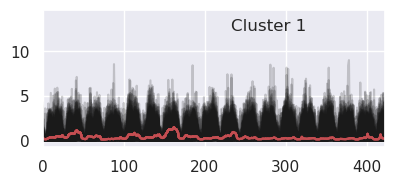

(427, 12720)
(427, 530, 24)
Init 1


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 427 out of 427 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 427 out of 427 | elapsed:    0.6s finished


5824.179 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 427 out of 427 | elapsed:    0.6s finished


3898.263 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 427 out of 427 | elapsed:    0.6s finished


3895.805 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 427 out of 427 | elapsed:    0.6s finished


3894.866 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 427 out of 427 | elapsed:    0.6s finished


3894.866 --> 
Init 2


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 427 out of 427 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 427 out of 427 | elapsed:    0.6s finished


6080.955 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 427 out of 427 | elapsed:    0.6s finished


3908.952 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 427 out of 427 | elapsed:    0.6s finished


3906.143 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 427 out of 427 | elapsed:    0.6s finished


3906.139 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 427 out of 427 | elapsed:    0.6s finished


3906.139 --> 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 427 out of 427 | elapsed:    0.6s finished


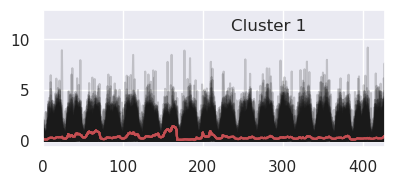

In [63]:
method = "DBA"

SDTW_result = {}
# barycenter_df = pd.DataFrame(columns=['MeterID', 'Day', 'FDI', 'overnight', 'breakfast', 'daytime', 'evening'])
pbar = tqdm(smart_meter_data_group)
count = 1
for area in pbar: # iterate 10 data groups
    X = []
    Y = []
    for meter in area['fdi']: # iterate every fdi meter in area 
        X.append(meter[ meter["Time"] % 2 == 1]["Electricity"].to_numpy())
        Y.append((meter["MeterID"].max(), 'True'))
    for meter in area['normal']: # iterate every fdi meter in area 
        X.append(meter[ meter["Time"] % 2 == 1]["Electricity"].to_numpy())
        Y.append((meter["MeterID"].max(), 'False'))
    X = np.array(X)
    print(X.shape)
    Y = np.array(Y)
    X = X.reshape(-1, 530, 24 )
    print(X.shape)
    y_pred, result = km_cluster(X, 1, method)
    SDTW_result[count] = (y_pred, result, result.cluster_centers_, Y)
    count = count + 1

In [127]:
one_cluster_dba_barycenter = []
for i in range(len(SDTW_result)):
    i = i + 1
    one_cluster_dba_barycenter.append(SDTW_result[i][2][0])
df = pd.DataFrame(np.array(one_cluster_dba_barycenter).reshape(-1, 530*24))
# df.head(), df.shape
e = df.to_csv(index=False)
f = open('one_cluster_dba_barycenter_24hours.csv','w')
f.write(e) #Give your csv text here.
f.close()

In [126]:
df.shape

(10, 12720)

### dba one cluster 48 hours

  0%|          | 0/10 [00:00<?, ?it/s]

(422, 25440)
(422, 530, 48)
Init 1


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.8s finished


58096.729 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.9s finished


9431.458 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.8s finished


9425.901 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.8s finished


9422.828 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.8s finished


9422.710 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.8s finished


9422.710 --> 
Init 2


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.8s finished


18642.404 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.8s finished


9374.522 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.8s finished


9372.856 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.8s finished


9372.856 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.8s finished


9372.856 --> 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.8s finished


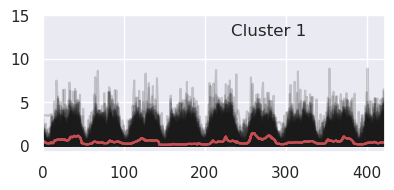

(422, 25440)
(422, 530, 48)
Init 1


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.8s finished


26994.307 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.8s finished


8510.298 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.8s finished


8508.930 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.8s finished


8508.930 --> 
Init 2


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.8s finished


14642.255 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.8s finished


8460.317 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.8s finished


8455.912 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.8s finished


8455.912 --> 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.7s finished


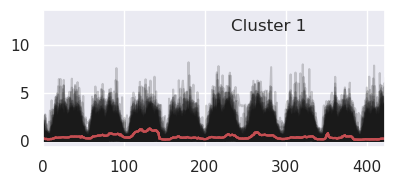

(422, 25440)
(422, 530, 48)
Init 1


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.8s finished


16915.618 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.8s finished


8888.065 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.8s finished


8882.891 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.8s finished


8882.891 --> 
Init 2


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.8s finished


18313.840 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.8s finished


8879.670 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.8s finished


8875.413 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.8s finished


8875.395 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.8s finished


8875.395 --> 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.8s finished


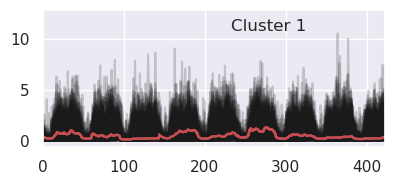

(422, 25440)
(422, 530, 48)
Init 1


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.8s finished


14824.915 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.8s finished


8538.051 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.8s finished


8530.026 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.8s finished


8524.006 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.8s finished


8523.999 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.8s finished


8523.999 --> 
Init 2


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.8s finished


13389.118 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.8s finished


8569.418 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.8s finished


8564.766 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.8s finished


8564.766 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.8s finished


8564.766 --> 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.8s finished


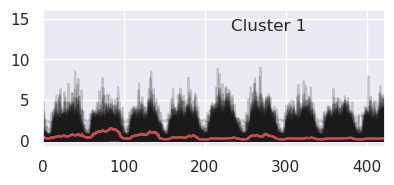

(422, 25440)
(422, 530, 48)
Init 1


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.8s finished


15847.980 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.8s finished


8558.943 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.8s finished


8557.004 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.8s finished


8557.004 --> 
Init 2


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.8s finished


15340.482 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.8s finished


8613.222 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.8s finished


8610.701 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.8s finished


8610.701 --> 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.8s finished


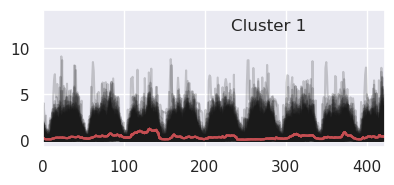

(422, 25440)
(422, 530, 48)
Init 1


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.8s finished


25708.268 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.8s finished


8488.221 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.8s finished


8477.314 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.8s finished


8476.256 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.8s finished


8476.227 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.8s finished


8476.227 --> 
Init 2


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.9s finished


14376.126 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.8s finished


8465.884 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.8s finished


8438.331 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.8s finished


8426.231 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.8s finished


8424.749 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.8s finished


8424.367 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.7s finished


8424.367 --> 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.8s finished


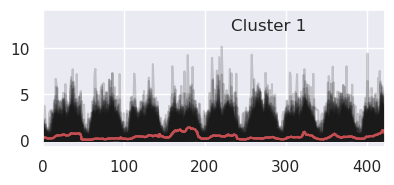

(422, 25440)
(422, 530, 48)
Init 1


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.8s finished


13899.226 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.8s finished


8934.960 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.8s finished


8932.414 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.8s finished


8932.414 --> 
Init 2


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.7s finished


19047.009 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.8s finished


8934.947 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.8s finished


8920.736 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.7s finished


8920.410 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.8s finished


8920.410 --> 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.8s finished


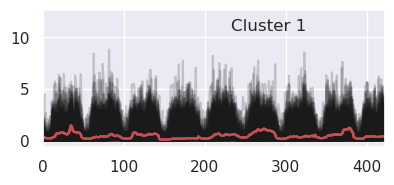

(422, 25440)
(422, 530, 48)
Init 1


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.8s finished


13189.568 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.8s finished


8428.262 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.8s finished


8397.500 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.7s finished


8394.620 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.8s finished


8394.620 --> 
Init 2


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.8s finished


20990.521 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.8s finished


8510.925 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.8s finished


8500.854 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.8s finished


8500.757 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.8s finished


8500.757 --> 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.7s finished


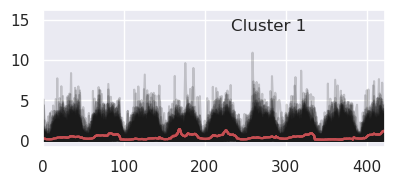

(422, 25440)
(422, 530, 48)
Init 1


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.7s finished


13599.889 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.8s finished


8180.204 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.9s finished


8176.803 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.8s finished


8176.803 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.8s finished


8176.803 --> 
Init 2


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.8s finished


16974.391 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.7s finished


8188.205 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.8s finished


8187.672 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.8s finished


8187.672 --> 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 422 out of 422 | elapsed:    0.8s finished


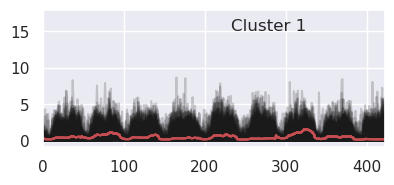

(427, 25440)
(427, 530, 48)
Init 1


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 427 out of 427 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 427 out of 427 | elapsed:    0.9s finished


12009.926 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 427 out of 427 | elapsed:    0.8s finished


7895.399 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 427 out of 427 | elapsed:    0.8s finished


7891.431 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 427 out of 427 | elapsed:    0.8s finished


7891.431 --> 
Init 2


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 427 out of 427 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 427 out of 427 | elapsed:    0.8s finished


12690.483 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 427 out of 427 | elapsed:    0.8s finished


7912.356 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 427 out of 427 | elapsed:    0.8s finished


7903.738 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 427 out of 427 | elapsed:    0.8s finished


7902.419 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 427 out of 427 | elapsed:    0.8s finished


7902.419 --> 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 427 out of 427 | elapsed:    0.8s finished


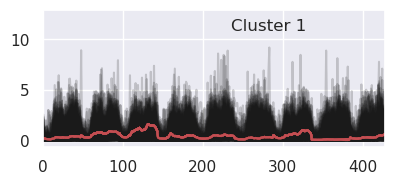

In [82]:
method = "DBA"

SDTW_result_48 = {}
# barycenter_df = pd.DataFrame(columns=['MeterID', 'Day', 'FDI', 'overnight', 'breakfast', 'daytime', 'evening'])
pbar = tqdm(smart_meter_data_group)
count = 1
for area in pbar: # iterate 10 data groups
    X = []
    Y = []
    for meter in area['fdi']: # iterate every fdi meter in area 
#         X.append(meter[ meter["Time"] % 2 == 1]["Electricity"].to_numpy())
        X.append(meter["Electricity"].to_numpy())
        Y.append((meter["MeterID"].max(), 'True'))
    for meter in area['normal']: # iterate every fdi meter in area 
#         X.append(meter[ meter["Time"] % 2 == 1]["Electricity"].to_numpy())
        X.append(meter["Electricity"].to_numpy())
        Y.append((meter["MeterID"].max(), 'False'))
    X = np.array(X)
    print(X.shape)
    Y = np.array(Y)
    X = X.reshape(-1, 530, 48 )
    print(X.shape)
    y_pred, result = km_cluster(X, 1, method)
    SDTW_result_48[count] = (y_pred, result, result.cluster_centers_, Y)
    count = count + 1

In [132]:
one_cluster_dba_barycenter_48 = []
for i in range(len(SDTW_result_48)):
    i = i + 1
    one_cluster_dba_barycenter_48.append(SDTW_result_48[i][2])
df = pd.DataFrame(np.array(one_cluster_dba_barycenter_48).reshape(10, 530*48))
df.shape

(10, 25440)

In [133]:
e = df.to_csv(index=False)
f = open('one_cluster_dba_barycenter_48hours.csv','w')
f.write(e) #Give your csv text here.
f.close()

## sdtw 24 hours

In [91]:
barycenter_result = {}
pbar = tqdm(smart_meter_data_group)
count = 1
for area in pbar: # iterate 10 data groups
    print(f'start {count}')
    X = []
    Y = []
    for meter in area['fdi']: # iterate every fdi meter in area 
        X.append(meter[ meter["Time"] % 2 == 1]["Electricity"].to_numpy())
        Y.append((meter["MeterID"].max(), 'True'))
    for meter in area['normal']: # iterate every fdi meter in area 
        X.append(meter[ meter["Time"] % 2 == 1]["Electricity"].to_numpy())
        Y.append((meter["MeterID"].max(), 'False'))
    X = np.array(X)
    print(X.shape)
    Y = np.array(Y)
    X = X.reshape(-1, 530, 24 )
    print(X.shape)
    result = softdtw_barycenter(X, max_iter=5, gamma=1.)
    barycenter_result[count] = (result, Y)
    count = count + 1

  0%|          | 0/10 [00:00<?, ?it/s]

start 1
(422, 12720)
(422, 530, 24)
start 2
(422, 12720)
(422, 530, 24)
start 3
(422, 12720)
(422, 530, 24)
start 4
(422, 12720)
(422, 530, 24)
start 5
(422, 12720)
(422, 530, 24)
start 6
(422, 12720)
(422, 530, 24)
start 7
(422, 12720)
(422, 530, 24)
start 8
(422, 12720)
(422, 530, 24)
start 9
(422, 12720)
(422, 530, 24)
start 10
(427, 12720)
(427, 530, 24)


In [100]:
t = softdtw_barycenter(X, max_iter=3, gamma=1.)

In [101]:
t.shape

(530, 24)

In [97]:
barycenter_result[1][0]

array([[0.40619797, 0.29890167, 0.24027405, ..., 0.75438166, 0.77675969,
        0.65795587],
       [0.34315413, 0.25324793, 0.20068616, ..., 0.48068981, 0.53533449,
        0.4997424 ],
       [0.29666166, 0.21705626, 0.14888657, ..., 0.4342095 , 0.44143211,
        0.48545515],
       ...,
       [0.4960421 , 0.35678242, 0.27988987, ..., 0.95341089, 0.84317983,
        0.73567295],
       [0.46053212, 0.33428006, 0.2651798 , ..., 0.77244042, 0.71802723,
        0.61414085],
       [0.28195866, 0.22515222, 0.18755831, ..., 0.47280275, 0.42208674,
        0.38288213]])

In [135]:
one_cluster_sdtw_barycenter_24 = []
for i in range(len(barycenter_result)):
    i = i + 1
    one_cluster_sdtw_barycenter_24.append(barycenter_result[i][0])


In [138]:
one_cluster_sdtw_barycenter_24[9].shape

(530, 24)

In [136]:
df = pd.DataFrame(np.array(one_cluster_sdtw_barycenter_24).reshape(10, 530*24))
df.shape

(10, 12720)

In [137]:
e = df.to_csv(index=False)
f = open('one_cluster_sdtw_barycenter_24.csv','w')
f.write(e) #Give your csv text here.
f.close()

In [ ]:

SDTW_result_1 = {}
# iterate 10 areas
for i in tq.tqdm(range(10)):

    
    data = final_data_group[i]
    for normal in data["fdi"]:
        X.append(normal["Electricity"].to_numpy())
        X_meter.append(normal["MeterID"].iloc[0])
        Y.append([0])
    for fdi in data["normal"]:
        X.append(fdi["Electricity"].to_numpy())
        X_meter.append(normal["MeterID"].iloc[0])
        Y.append([1])
        
    X = np.array(X)
    
    print(X.shape)
    
    
    SDTW_result_1[i] = (y_pred, result, result.cluster_centers_)
    se = {'MeterID': meter_id, 'Day': meter_day,'FDI': True, 'overnight': overnight, 'breakfast': breakfast, 'daytime': daytime, 'evening': evening}
    df_list.append(se)
    break

### calculate dwt score

In [159]:
from tslearn.metrics import soft_dtw, dtw

In [164]:
count = 0
df_list = []
dwt_df = pd.DataFrame(columns=['MeterID', 'Day', 'FDI', 'DTW', 'Soft DTW'])
for area in pbar: # iterate 10 data groups
    print(f'start {count}')
    y = center_dba_24.loc[0].to_numpy()
    for meter in area['fdi']: # iterate every fdi meter in area 
        meter_id = meter['MeterID'].max()
        x = meter[ meter["Time"] % 2 == 1]["Electricity"].to_numpy()
        meter_dtw = dtw(x,y)
        meter_sdtw = soft_dtw(x,y)
        se = {'MeterID': meter_id, 'FDI': True, 'DTW': meter_dtw, 'Soft DTW': meter_sdtw}
        df_list.append(se)
    for meter in area['normal']: # iterate every fdi meter in area 
        meter_id = meter['MeterID'].max()
        x = meter[ meter["Time"] % 2 == 1]["Electricity"].to_numpy()
        meter_dtw = dtw(x,y)
        meter_sdtw = soft_dtw(x,y)
        se = {'MeterID': meter_id, 'FDI': False, 'DTW': meter_dtw, 'Soft DTW': meter_sdtw}
        df_list.append(se)
    count = count + 1

start 0


KeyboardInterrupt: 

In [139]:
center_dba_24 = pd.read_csv('one_cluster_dba_barycenter_24hours.csv')
center_dba_24.shape

(10, 12720)

In [153]:
center_dba_24.loc[0].to_numpy().max(), center_dba_24.loc[1].to_numpy().max()

(4.674621261377913, 2.3085703342481176)

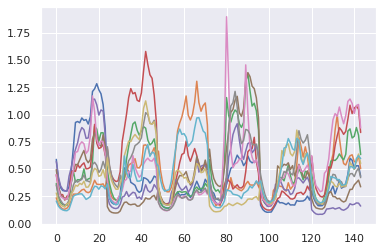

In [158]:
for i in range(10):
    plt.plot(center_dba_24.loc[i][:144].to_numpy())

### merge feature(vvalue)

In [ ]:
temp = pd.read_csv('v_value.csv')

In [ ]:
temp

In [ ]:
new_df = pd.merge(A_df, temp,  how='left', left_on=['A_c1','c2'], right_on = ['B_c1','c2'])

In [58]:
# normalized smart_meter_data_group by divide the max eletricity of the meter
for area in smart_meter_data_group:
    for meter in area['fdi']:
        meter_numpy = meter['Electricity'].to_numpy()
        meter['Electricity'] = meter_numpy / meter_numpy.max()
    for meter in area['normal']:
        meter_numpy = meter['Electricity'].to_numpy()
        meter['Electricity'] = meter_numpy / meter_numpy.max()
smart_meter_data_group[0]['fdi'][0]['Electricity'].to_numpy()

array([0.1206073 , 0.12691914, 0.0996247 , ..., 0.07830092, 0.14738997,
       0.08103037])